In [ ]:
import pandas as pd
import numpy as np
import re #untuk regex
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE #menangani data tidak seimbangg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_raw = pd.read_csv("/content/drive/MyDrive/uas ka/emotional-reactions-reddit.csv")
df_raw.head()

,sp_id,rp_id,seeker_post,response_post,level,rationales
0,65m92s,dgbdk7z,Help. Help me. I dunno what I'm doing anymore,"That's pretty vague, do you not know what you'...",0,NaN
1,9ezsfi,e5t3oxh,I'm done saying I love you to her because I do...,idk what a Red pill means exactly but my advic...,0,NaN
2,6b2cmc,dhj8tcb,Always feel like I'm being criticized and mock...,"I think it's social anxiety , that creates par...",0,NaN
3,8iz0as,dyvq1ne,My diet becomes fucked when i get depressed.. ...,By any chance do you think you're in a loop. J...,0,NaN
4,aow3l9,eg40ecq,I hate not knowing why. I was diagnosed with d...,depression. not sadness which is caused by som...,0,NaN


# EDA DATASET

In [ ]:
df_raw.info() #struktur dan tipe kolom

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sp_id          3084 non-null   object
 1   rp_id          3084 non-null   object
 2   seeker_post    3084 non-null   object
 3   response_post  3084 non-null   object
 4   level          3084 non-null   int64 
 5   rationales     1045 non-null   object
dtypes: int64(1), object(5)
memory usage: 144.7+ KB


In [ ]:
df_raw.duplicated().sum() #jumlah data yang duplikat

np.int64(33)

In [ ]:
df_raw.columns

Index(['sp_id', 'rp_id', 'seeker_post', 'response_post', 'level',
       'rationales'],
      dtype='object')

In [ ]:
print("Jumlah total data:", len(df_raw))
df_raw['level'].value_counts() #distribusi data pada setiap label

Jumlah total data: 3084


,count
level,
0,2037
1,895
2,152


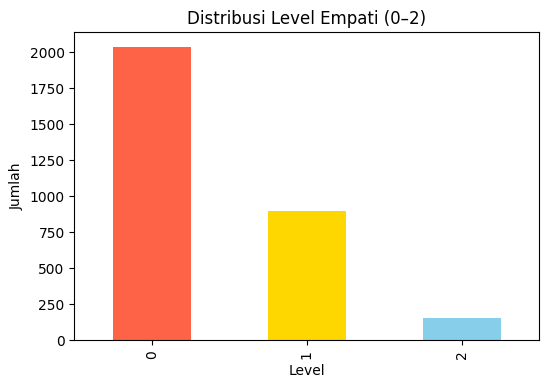

In [ ]:
import matplotlib.pyplot as plt

df_raw['level'].value_counts().sort_index().plot(
    kind='bar', figsize=(6,4), color=['tomato','gold','skyblue']
)

plt.title("Distribusi Level Empati (0–2)") #sebelum di buat menjadi biner 0 dan 1
plt.xlabel("Level")
plt.ylabel("Jumlah")
plt.show()

In [ ]:
df_raw['label_empati'] = df_raw['level'].apply(lambda x: 1 if x > 0 else 0) #mengubah label menjadi biner, empatik 1, dan tidak empatik 0

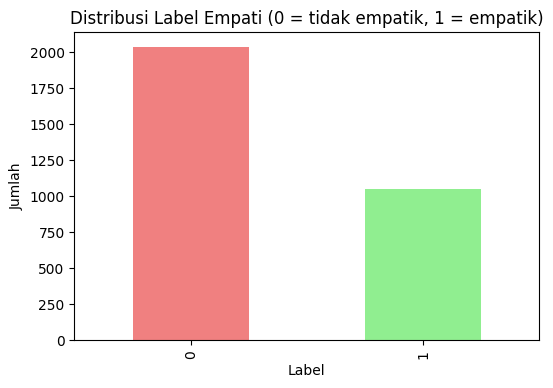

In [ ]:
df_raw['label_empati'].value_counts().plot(
    kind='bar',
    figsize=(6,4),
    color=['lightcoral','lightgreen']
)

plt.title("Distribusi Label Empati (0 = tidak empatik, 1 = empatik)")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

In [ ]:
df_raw['text_length'] = df_raw['response_post'].astype(str).str.split().apply(len) #menghitung jumlah kata pada tiap balasan

In [ ]:
df_raw['text_length'].describe() #statistik panjang teks balasann

,text_length
count,3084.000000
mean,46.733787
std,68.743159
min,5.000000
25%,14.000000
50%,28.000000
75%,56.000000
max,1811.000000


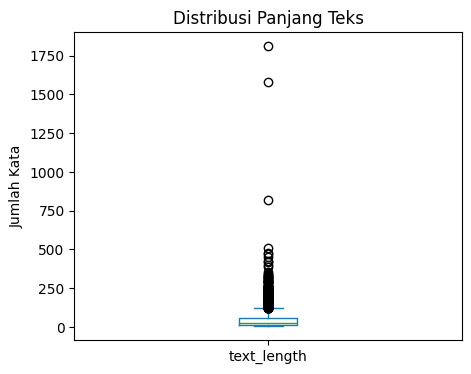

In [ ]:
df_raw['text_length'].plot(kind='box', figsize=(5,4)) #sebaran panjang teks
plt.title("Distribusi Panjang Teks")
plt.ylabel("Jumlah Kata")
plt.show()

In [ ]:
from collections import Counter
import re

all_words = " ".join(df_raw['response_post'].astype(str)).lower() #menggabingkan seluruh teks lalu dilakukan case folding
all_words = re.sub(r'[^a-zA-Z\s]', '', all_words)  # hapus simbol
word_list = all_words.split() #dipecah jadi per kata

word_counts = Counter(word_list).most_common(20)
word_counts

[('i', 5464),
 ('to', 4821),
 ('you', 4350),
 ('and', 3583),
 ('the', 3334),
 ('a', 3025),
 ('it', 2664),
 ('that', 2219),
 ('of', 2015),
 ('is', 1677),
 ('in', 1494),
 ('but', 1469),
 ('my', 1431),
 ('for', 1391),
 ('me', 1256),
 ('have', 1146),
 ('be', 1124),
 ('your', 1105),
 ('just', 1054),
 ('if', 1030)]

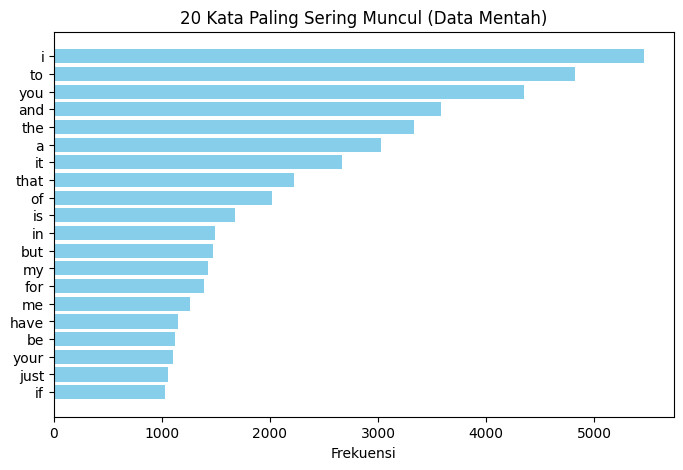

In [ ]:
words, counts = zip(*word_counts)

plt.figure(figsize=(8,5))
plt.barh(words, counts, color='skyblue')
plt.gca().invert_yaxis()
plt.title("20 Kata Paling Sering Muncul (Data Mentah)")
plt.xlabel("Frekuensi")
plt.show()

In [ ]:
df_raw = df_raw[['response_post', 'seeker_post', 'level']].dropna() #memilih hanya 3 kolom, dan menghapus data kosong
df_raw = df_raw.reset_index(drop=True) #reset index agar sesuai setelah penghapusan data kosong
df_raw.head()

,response_post,seeker_post,level
0,"That's pretty vague, do you not know what you'...",Help. Help me. I dunno what I'm doing anymore,0
1,idk what a Red pill means exactly but my advic...,I'm done saying I love you to her because I do...,0
2,"I think it's social anxiety , that creates par...",Always feel like I'm being criticized and mock...,0
3,By any chance do you think you're in a loop. J...,My diet becomes fucked when i get depressed.. ...,0
4,depression. not sadness which is caused by som...,I hate not knowing why. I was diagnosed with d...,0


In [ ]:
df_raw['label_empati'] = df_raw['level'].apply(lambda x: 1 if x > 0 else 0) #convert label tidak empatik = 0, dan empatik = 1 & 2
df_raw['label_empati'].value_counts()

,count
label_empati,
0,2037
1,1047


# PRE-PROCESSING (respone)

In [ ]:
df = df_raw.copy()
df.head()

,response_post,seeker_post,level,label_empati
0,"That's pretty vague, do you not know what you'...",Help. Help me. I dunno what I'm doing anymore,0,0
1,idk what a Red pill means exactly but my advic...,I'm done saying I love you to her because I do...,0,0
2,"I think it's social anxiety , that creates par...",Always feel like I'm being criticized and mock...,0,0
3,By any chance do you think you're in a loop. J...,My diet becomes fucked when i get depressed.. ...,0,0
4,depression. not sadness which is caused by som...,I hate not knowing why. I was diagnosed with d...,0,0


In [ ]:
def remove_punct(text): #hapus tanda baca
    return text.translate(str.maketrans("", "", string.punctuation))

df["lowercase"] = df["response_post"].str.lower() #di ubah jadi lowercase
df["no_punct"] = df["lowercase"].apply(remove_punct)
df[["response_post", "lowercase", "no_punct"]].head()

,response_post,lowercase,no_punct
0,"That's pretty vague, do you not know what you'...","that's pretty vague, do you not know what you'...",thats pretty vague do you not know what youre ...
1,idk what a Red pill means exactly but my advic...,idk what a red pill means exactly but my advic...,idk what a red pill means exactly but my advic...
2,"I think it's social anxiety , that creates par...","i think it's social anxiety , that creates par...",i think its social anxiety that creates paran...
3,By any chance do you think you're in a loop. J...,by any chance do you think you're in a loop. j...,by any chance do you think youre in a loop jun...
4,depression. not sadness which is caused by som...,depression. not sadness which is caused by som...,depression not sadness which is caused by some...


In [ ]:
def remove_numbers(text): #hapus angka
    return re.sub(r'\d+', '', text)

df["no_numbers"] = df["no_punct"].apply(remove_numbers)
df[["label_empati", "no_punct", "no_numbers"]].head()

,label_empati,no_punct,no_numbers
0,0,thats pretty vague do you not know what youre ...,thats pretty vague do you not know what youre ...
1,0,idk what a red pill means exactly but my advic...,idk what a red pill means exactly but my advic...
2,0,i think its social anxiety that creates paran...,i think its social anxiety that creates paran...
3,0,by any chance do you think youre in a loop jun...,by any chance do you think youre in a loop jun...
4,0,depression not sadness which is caused by some...,depression not sadness which is caused by some...


In [ ]:
def clean_spaces(text): #membersihkan spasi
    return " ".join(text.split())

df["clean_spaces"] = df["no_numbers"].apply(clean_spaces)
df[["label_empati", "no_numbers", "clean_spaces"]].head()

,label_empati,no_numbers,clean_spaces
0,0,thats pretty vague do you not know what youre ...,thats pretty vague do you not know what youre ...
1,0,idk what a red pill means exactly but my advic...,idk what a red pill means exactly but my advic...
2,0,i think its social anxiety that creates paran...,i think its social anxiety that creates parano...
3,0,by any chance do you think youre in a loop jun...,by any chance do you think youre in a loop jun...
4,0,depression not sadness which is caused by some...,depression not sadness which is caused by some...


In [ ]:
def tokenize(text): #pecah jadi per kata
    return text.split()

df["tokenized"] = df["clean_spaces"].apply(tokenize)
df[["label_empati","clean_spaces", "tokenized"]].head()

,label_empati,clean_spaces,tokenized
0,0,thats pretty vague do you not know what youre ...,"[thats, pretty, vague, do, you, not, know, wha..."
1,0,idk what a red pill means exactly but my advic...,"[idk, what, a, red, pill, means, exactly, but,..."
2,0,i think its social anxiety that creates parano...,"[i, think, its, social, anxiety, that, creates..."
3,0,by any chance do you think youre in a loop jun...,"[by, any, chance, do, you, think, youre, in, a..."
4,0,depression not sadness which is caused by some...,"[depression, not, sadness, which, is, caused, ..."


# Feature Engineering

In [ ]:
X = df["clean_spaces"] #teks
y = df["label_empati"] #label

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) #80% data latih 20% data uji

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,1)
) #unigram/kata tunggal dengan maksimal 5000 fitur

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [ ]:
feature_names = tfidf.get_feature_names_out() #mendapatkan daftar kata fitur
print(feature_names[:20])    # lihat 20 kata pertama

['abandon' 'abandoned' 'abandonment' 'abdominal' 'abi' 'abilities'
 'ability' 'abillity' 'abit' 'ablaze' 'able' 'abortion' 'about' 'abouts'
 'above' 'absolute' 'absolutely' 'absolutly' 'abuse' 'abused']


In [ ]:
tfidf_vector = X_train_tfidf[0]
df_tfidf = pd.DataFrame(
    tfidf_vector.T.todense(),
    index=feature_names,
    columns=["tfidf"]
)
df_tfidf.sort_values(by="tfidf", ascending=False).head(10)

,tfidf
do,0.586302
whatever,0.553605
need,0.422623
you,0.375212
to,0.174289
pages,0.000000
page,0.000000
padding,0.000000
packing,0.000000
packages,0.000000


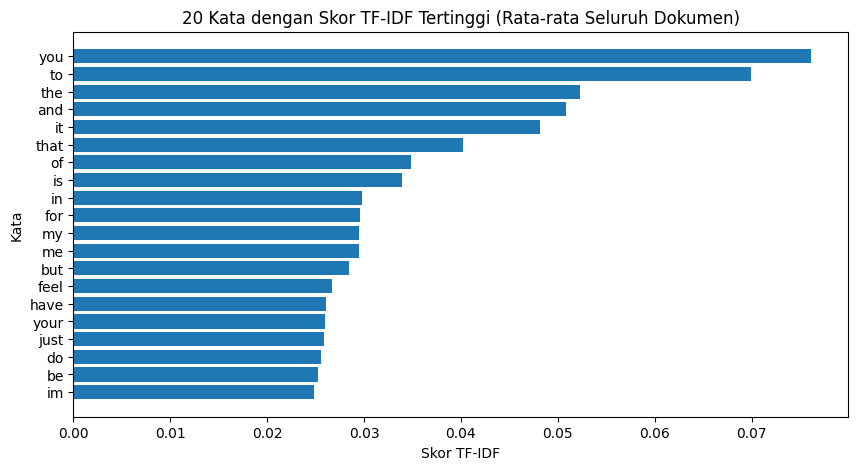

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

avg_tfidf = np.mean(X_train_tfidf.toarray(), axis=0)

df_tfidf = pd.DataFrame({
    "kata": feature_names,
    "tfidf": avg_tfidf
})

top_features = df_tfidf.sort_values(by="tfidf", ascending=False).head(20)

# Plot
plt.figure(figsize=(10,5))
plt.barh(top_features["kata"], top_features["tfidf"])
plt.gca().invert_yaxis()
plt.title("20 Kata dengan Skor TF-IDF Tertinggi (Rata-rata Seluruh Dokumen)")
plt.xlabel("Skor TF-IDF")
plt.ylabel("Kata")
plt.show()

# Naive Bayes (Baseline)

In [ ]:
nb_model = MultinomialNB() #training naive bayes baseline
nb_model.fit(X_train_tfidf, y_train)
print("Model selesai dilatih")

Model selesai dilatih


In [ ]:
y_pred = nb_model.predict(X_test_tfidf)
list(zip(y_test[:10], y_pred[:10])) #format hasilnya label asli, label prediksi

[(0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0))]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model Naive Bayes: {accuracy:.4f}")

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Presisis Model Naive Bayes : {precision}")

recall = recall_score(y_test, y_pred, average='weighted',  zero_division=0)
print(f"Recall Model Naive Bayes : {recall}")

f1 = f1_score(y_test, y_pred, average='weighted',  zero_division=0)
print(f"F1 Score Model Naive Bayes : {f1}")

Akurasi Model Naive Bayes: 0.7066
Presisis Model Naive Bayes : 0.7598735388823779
Recall Model Naive Bayes : 0.706645056726094
F1 Score Model Naive Bayes : 0.6278260081709568


In [ ]:
print("Classification Report :")
print(classification_report(y_test, y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       409
           1       0.89      0.15      0.26       208

    accuracy                           0.71       617
   macro avg       0.79      0.57      0.54       617
weighted avg       0.76      0.71      0.63       617



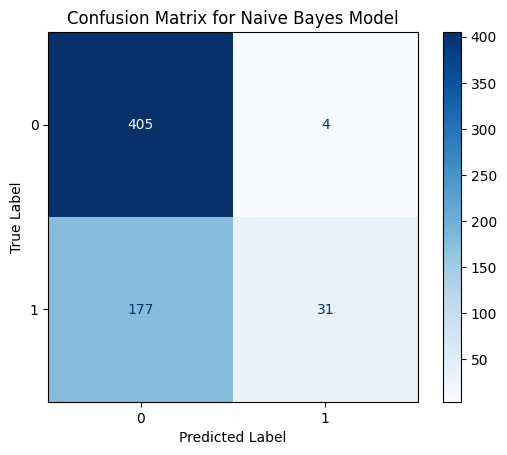

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay #confusion matrix
import matplotlib.pyplot as plt

cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

cm_display.ax_.set_title('Confusion Matrix for Naive Bayes Model')
cm_display.ax_.set_xlabel('Predicted Label')
cm_display.ax_.set_ylabel('True Label')

plt.show()

In [ ]:
hasil = pd.DataFrame({
    "teks": X_test,
    "label_asli": y_test,
    "prediksi_model": y_pred
})

hasil.head(20)

,teks,label_asli,prediksi_model
1505,you piece of shit how dare you make such an in...,0,0
2398,when i watch filmsunable to concentrate on any...,0,0
1814,im in my s and have been struggling with depre...,0,0
511,i know that when everything seems futile to me...,0,0
1565,i used to do nothing all day now i do gym at l...,0,0
790,wish i could do this but unfortunately id get ...,0,0
354,the only time i leave my house is to go to wor...,0,0
1651,would you feel better sticking to a renewed pr...,0,0
2858,thats it youve discovered how things work what...,0,0
408,this a huge trollcheck his post history,0,0


In [ ]:
hasil["label_asli_text"] = hasil["label_asli"].apply(lambda x: "empatik" if x == 1 else "tidak empatik")
hasil["prediksi_text"] = hasil["prediksi_model"].apply(lambda x: "empatik" if x == 1 else "tidak empatik")

hasil[["teks", "label_asli_text", "prediksi_text"]].head(100)

,teks,label_asli_text,prediksi_text
1505,you piece of shit how dare you make such an in...,tidak empatik,tidak empatik
2398,when i watch filmsunable to concentrate on any...,tidak empatik,tidak empatik
1814,im in my s and have been struggling with depre...,tidak empatik,tidak empatik
511,i know that when everything seems futile to me...,tidak empatik,tidak empatik
1565,i used to do nothing all day now i do gym at l...,tidak empatik,tidak empatik
...,...,...,...
857,the amount of plumber and garbage man jokes th...,tidak empatik,tidak empatik
346,i can relate the only place i try is at work a...,empatik,tidak empatik
691,one of my friends got better like not just tem...,tidak empatik,tidak empatik
1200,no only you can make yourself happy other peop...,tidak empatik,tidak empatik


## Naive Bayes dengan SMOTE

In [ ]:
print("Distribusi label SEBELUM SMOTE:") #menyeimbangkan kelas minoritas
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("\nDistribusi label SESUDAH SMOTE:")
print(pd.Series(y_train_smote).value_counts())#menyeimbsngkan jumlah kelas

Distribusi label SEBELUM SMOTE:
label_empati
0    1628
1     839
Name: count, dtype: int64

Distribusi label SESUDAH SMOTE:
label_empati
0    1628
1    1628
Name: count, dtype: int64


In [ ]:
nb_model = MultinomialNB() #training model
nb_model.fit(X_train_smote, y_train_smote)

print("Model Naive Bayes selesai dilatih (dengan SMOTE)")

Model Naive Bayes selesai dilatih (dengan SMOTE)


In [ ]:
y_pred = nb_model.predict(X_test_tfidf)
list(zip(y_test[:10], y_pred[:10]))

[(0, np.int64(1)),
 (0, np.int64(0)),
 (0, np.int64(1)),
 (0, np.int64(1)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(0)),
 (0, np.int64(1)),
 (0, np.int64(1)),
 (0, np.int64(1))]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model Naive Bayes: {accuracy:.4f}")

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Presisis Model Naive Bayes : {precision}")

recall = recall_score(y_test, y_pred, average='weighted',  zero_division=0)
print(f"Recall Model Naive Bayes : {recall}")

f1 = f1_score(y_test, y_pred, average='weighted',  zero_division=0)
print(f"F1 Score Model Naive Bayes : {f1}")

Akurasi Model Naive Bayes: 0.6548
Presisis Model Naive Bayes : 0.7554795753992042
Recall Model Naive Bayes : 0.6547811993517018
F1 Score Model Naive Bayes : 0.6610775758157257


In [ ]:
print("Classification Report :")
print(classification_report(y_test, y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       409
           1       0.49      0.87      0.63       208

    accuracy                           0.65       617
   macro avg       0.69      0.71      0.65       617
weighted avg       0.76      0.65      0.66       617



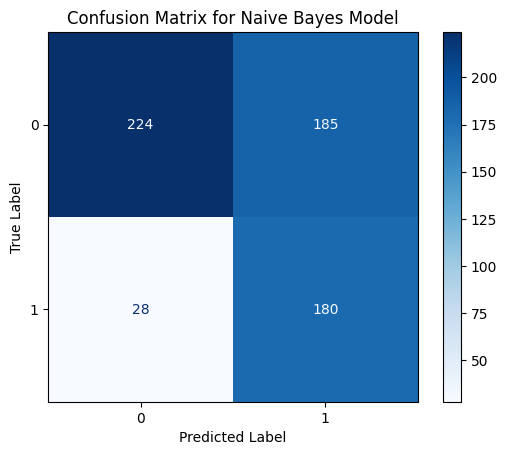

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay #confusion matrix
import matplotlib.pyplot as plt

cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

cm_display.ax_.set_title('Confusion Matrix for Naive Bayes Model')
cm_display.ax_.set_xlabel('Predicted Label')
cm_display.ax_.set_ylabel('True Label')

plt.show()

In [ ]:
hasil_smote = pd.DataFrame({
    "teks": X_test,
    "label_asli": y_test,
    "prediksi_model": y_pred
})

hasil_smote.head(20)

,teks,label_asli,prediksi_model
1505,you piece of shit how dare you make such an in...,0,1
2398,when i watch filmsunable to concentrate on any...,0,0
1814,im in my s and have been struggling with depre...,0,1
511,i know that when everything seems futile to me...,0,1
1565,i used to do nothing all day now i do gym at l...,0,0
790,wish i could do this but unfortunately id get ...,0,0
354,the only time i leave my house is to go to wor...,0,0
1651,would you feel better sticking to a renewed pr...,0,1
2858,thats it youve discovered how things work what...,0,1
408,this a huge trollcheck his post history,0,1


# PERBANDINGAN

In [ ]:
nb_baseline = MultinomialNB()
nb_baseline.fit(X_train_tfidf, y_train)

y_pred_baseline = nb_baseline.predict(X_test_tfidf)

baseline_metrics = {
    "Model": "Naive Bayes (Baseline)",
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_baseline, average="weighted", zero_division=0),
    "F1-Score": f1_score(y_test, y_pred_baseline, average="weighted", zero_division=0)
}


In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

nb_smote = MultinomialNB()
nb_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = nb_smote.predict(X_test_tfidf)

smote_metrics = {
    "Model": "Naive Bayes + SMOTE",
    "Accuracy": accuracy_score(y_test, y_pred_smote),
    "Precision": precision_score(y_test, y_pred_smote, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_smote, average="weighted", zero_division=0),
    "F1-Score": f1_score(y_test, y_pred_smote, average="weighted", zero_division=0)
}

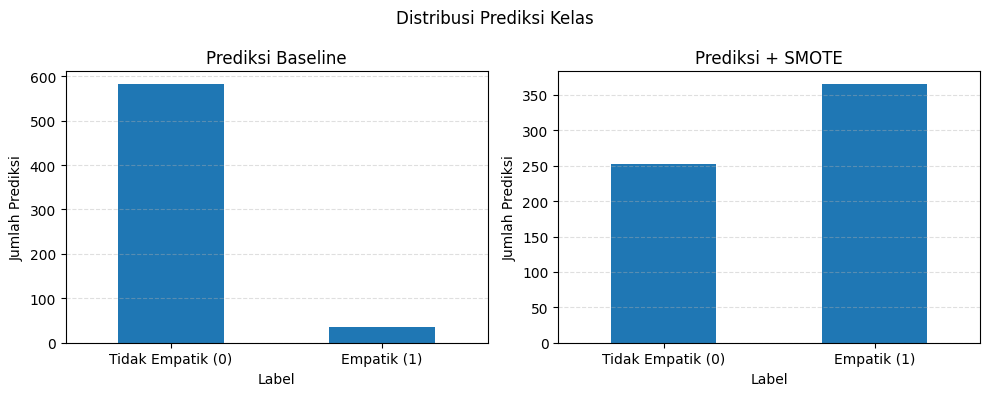

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

pd.Series(y_pred_baseline).value_counts().sort_index().plot(
    kind="bar", ax=axes[0], title="Prediksi Baseline"
)

pd.Series(y_pred_smote).value_counts().sort_index().plot(
    kind="bar", ax=axes[1], title="Prediksi + SMOTE"
)

for ax in axes:
    ax.set_xlabel("Label")
    ax.set_ylabel("Jumlah Prediksi")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(
        ["Tidak Empatik (0)", "Empatik (1)"],
        rotation=0,
        ha="center"
    )

    ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.suptitle("Distribusi Prediksi Kelas")
plt.tight_layout()
plt.show()

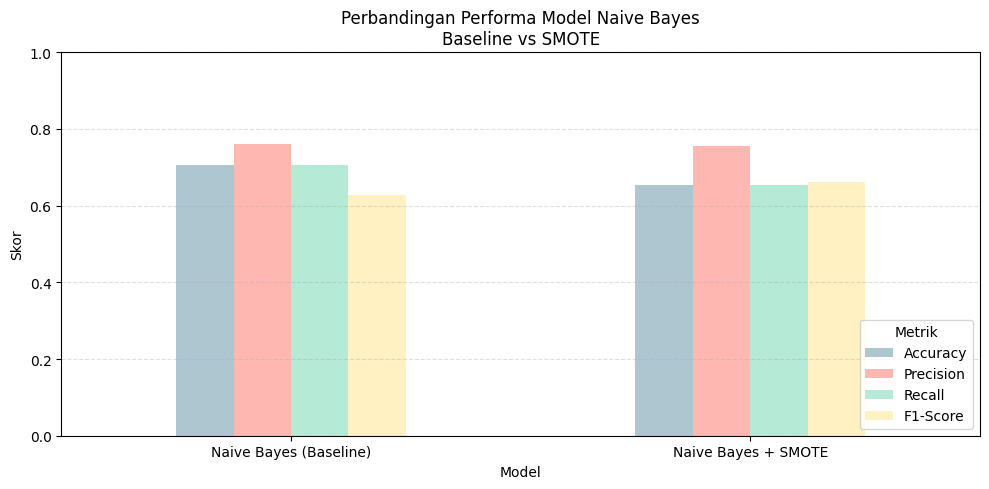

In [ ]:
pastel_colors = [
    "#AEC6CF",  # pastel blue
    "#FFB7B2",  # pastel pink
    "#B5EAD7",  # pastel green
    "#FFF1C1"   # pastel yellow
]

ax = df_plot.plot(
    kind="bar",
    figsize=(10,5),
    color=pastel_colors
)

plt.title("Perbandingan Performa Model Naive Bayes\nBaseline vs SMOTE")
plt.ylabel("Skor")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)

ax.legend(title="Metrik", loc="lower right")
plt.tight_layout()
plt.show()
